Вариант:
![Задача](task.png)


Решить выбранную СЛАУ следующими методами (постараться избежать умножения матриц, использовать поэлементные записи, методичек накидал, где посмотреть): 

1) метод Гаусса с выбором главного элемента
2) метод LU-разложения (если применим)
3) метод Якоби
4) метод Зейделя
5) метод верхней релаксации
6) * Метод градиентного спуска
7) * Метод минимальных невязок
8) * Стабилизированный метод
бисопряженных градиентов

*Для итерационных методов получить график убывания невязки в зависимости от итерации.

In [99]:
# импорт необходимых библиотек и задание исследуемой СЛАУ
import numpy as np

n = 100
a = b = 10
A = np.zeros((n, n))

for i in range(n):
    A[i, i] = a
    if i + 1 < n:
        A[i, i+1] = 1
        A[i+1, i] = 1
    if i + 2 < n:
        A[i, i+2] = 1 / b
        
f = np.arange(1, n+1)

# Метод Гаусса с выбором главного элемента

In [91]:
def gauss_with_pivoting(A, f):
    n = len(f)
    
    for i in range(n):
        max_elem_row = np.argmax(np.abs(A[i:, i])) + i
        if A[max_elem_row, i] == 0:
            raise ValueError("Матрица вырождена!")
        if max_elem_row != i:
            A[[i, max_elem_row]] = A[[max_elem_row, i]]
            f[[i, max_elem_row]] = f[[max_elem_row, i]]
        
        pivot = A[i, i]
        A[i] = A[i] / pivot
        f[i] = f[i] / pivot
        
        for j in range(i + 1, n):
            factor = A[j, i]
            A[j] = A[j] - factor * A[i]
            f[j] = f[j] - factor * f[i]

    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = f[i] - np.dot(A[i, i + 1:], x[i + 1:])
    
    return x


In [92]:
A_copy = A.copy()
f_copy = f.copy()

u = gauss_with_pivoting(A_copy, f_copy)

#проверка
diff = np.dot(A, u) - f
max_error = round(np.max(np.abs(diff)), 4)

max_error

np.float64(9.7999)

# LU-разложение

In [93]:
def lu_decomposition(A):
    n = len(A)
    L = np.zeros_like(A)
    U = np.zeros_like(A)
    
    for i in range(n):
        L[i, i] = 1
        for j in range(i, n):
            U[i, j] = A[i, j] - np.dot(L[i, :i], U[:i, j])
        for j in range(i + 1, n):
            if U[i, i] == 0:
                raise ValueError("Нулевой элемент на главной диагонали, невозможно выполнить разложение!")
            L[j, i] = (A[j, i] - np.dot(L[j, :i], U[:i, i])) / U[i, i]
    
    return L, U

def forward_substitution(L, b):
    n = len(b)
    y = np.zeros_like(b)
    for i in range(n):
        y[i] = b[i] - np.dot(L[i, :i], y[:i])
    return y

def backward_substitution(U, y):
    n = len(y)
    x = np.zeros_like(y)
    for i in range(n-1, -1, -1):
        if U[i, i] == 0:
            raise ValueError("Нулевой элемент на главной диагонали, невозможно выполнить обратную подстановку!")
        x[i] = (y[i] - np.dot(U[i, i+1:], x[i+1:])) / U[i, i]
    return x

In [102]:
A_copy = A.copy()
f_copy = f.copy()

L, U = lu_decomposition(A_copy)

y = forward_substitution(L, f_copy)
u = backward_substitution(U, y)

#проверка
diff = np.dot(A, u) - f
max_error = round(np.max(np.abs(diff)), 4)

max_error

np.float64(10.9)

## отмасштабироуем матрицу

In [101]:
def scale_matrix(A, f):
    n = A.shape[0]
    for i in range(n):
        max_val = np.max(np.abs(A[i, :]))
        if max_val > 0:
            A[i, :] = A[i, :] / max_val
            f[i] = f[i] / max_val
    return A, f

In [106]:
A_scaled, f_scaled = scale_matrix(A.copy(), f.copy())

u = gauss_with_pivoting(A_scaled, f_scaled)

diff = np.dot(A_scaled, u) - f_scaled
max_error = round(np.max(np.abs(diff)), 4)

max_error

np.float64(0.0)

In [107]:
A_scaled, f_scaled = scale_matrix(A.copy(), f.copy())
L, U = lu_decomposition(A_scaled)

y = forward_substitution(L, f_scaled)
u = backward_substitution(U, y)

diff = np.dot(A_scaled, u) - f_scaled
max_error = round(np.max(np.abs(diff)), 4)

max_error

np.float64(1.9)

# Итерационные методы

In [87]:
import matplotlib.pyplot as plt

# подсчет невязки
def calculate_residual(A, u, f):
    return np.linalg.norm(np.dot(A, u) - f)

def jacobi(A, f, tol=1e-16, max_iterations=60):
    n = len(f)
    x = np.zeros(n)
    x_new = np.zeros(n)
    residuals = []
    
    for k in range(max_iterations):
        for i in range(n):
            sum1 = sum(A[i, j] * x[j] for j in range(n) if j != i)  
            x_new[i] = (f[i] - sum1) / A[i, i]
        
        residual = np.linalg.norm(np.dot(A, x_new) - f)
        residuals.append(residual)
        
        if residual < tol:
            break
        
        x[:] = x_new[:]
    
    return x, residuals

def seidel(A, f, tol=1e-16, max_iterations=60):
    n = len(f)
    x = np.zeros(n)
    residuals = []
    
    for k in range(max_iterations):
        for i in range(n):
            sum1 = sum(A[i, j] * x[j] for j in range(i))     
            sum2 = sum(A[i, j] * x[j] for j in range(i + 1, n))  
            x[i] = (f[i] - sum1 - sum2) / A[i, i]
        
        residual = np.linalg.norm(np.dot(A, x) - f)
        residuals.append(residual)
        
        if residual < tol:
            break
    
    return x, residuals

def sor(A, f, omega=1.25, tol=1e-16, max_iterations=60):
    n = len(f)
    x = np.zeros(n)
    residuals = []
    
    for k in range(max_iterations):
        x_new = np.copy(x)
        for i in range(n):
            sum1 = sum(A[i, j] * x_new[j] for j in range(i))     
            sum2 = sum(A[i, j] * x[j] for j in range(i + 1, n))  
            x_new[i] = (1 - omega) * x[i] + (omega / A[i, i]) * (f[i] - sum1 - sum2)
        
        residual = np.linalg.norm(np.dot(A, x_new) - f)
        residuals.append(residual)
        
        if residual < tol:
            break
        
        x[:] = x_new[:]
    
    return x, residuals

def gradient_descent(A, f, tol=1e-16, max_iterations=60):
    n = len(f)
    u = np.zeros(n)
    residuals = []
    
    for i in range(max_iterations):
        r = f - np.dot(A, u)
        alpha = np.dot(r, r) / np.dot(np.dot(A, r), r)
        u = u + alpha * r
        
        residual = calculate_residual(A, u, f)
        residuals.append(residual)
        
        if residual < tol:
            break
    
    return u, residuals

def least_squares(A, f, tol=1e-16, max_iterations=60):
    n = len(f)
    u = np.zeros(n)
    residuals = []
    
    for i in range(max_iterations):
        r = f - np.dot(A, u)
        Ar = np.dot(A, r)
        alpha = np.dot(Ar, r) / np.dot(Ar, Ar)
        u = u + alpha * r
        
        residual = calculate_residual(A, u, f)
        residuals.append(residual)
        
        if residual < tol:
            break
    
    return u, residuals

def bicgstab(A, b, tol=1e-16, max_iterations=60):
    n = len(b)
    x = np.zeros(n)
    r = b - np.dot(A, x)  
    r_hat = np.copy(r)     
    
    residuals = []
    
    rho_old = alpha = omega = 1.0
    v = p = np.zeros(n)
    
    for i in range(max_iterations):
        rho_new = np.dot(r_hat, r)
        if rho_new == 0:
            raise ValueError("Метод не может решить данную систему (ρ = 0)")
        
        if i == 0:
            p = np.copy(r)
        else:
            beta = (rho_new / rho_old) * (alpha / omega)
            p = r + beta * (p - omega * v)
        
        v = np.dot(A, p)
        alpha = rho_new / np.dot(r_hat, v)
        s = r - alpha * v
        
        if np.linalg.norm(s) / np.linalg.norm(b) < tol:
            x = x + alpha * p
            residuals.append(np.linalg.norm(s) / np.linalg.norm(b))
            break
        
        t = np.dot(A, s)
        omega = np.dot(t, s) / np.dot(t, t)
        x = x + alpha * p + omega * s
        
        r = s - omega * t
        
        residuals.append(np.linalg.norm(r) / np.linalg.norm(b))
        
        if np.linalg.norm(r) / np.linalg.norm(b) < tol:
            break
        
        rho_old = rho_new
    
    return x, residuals


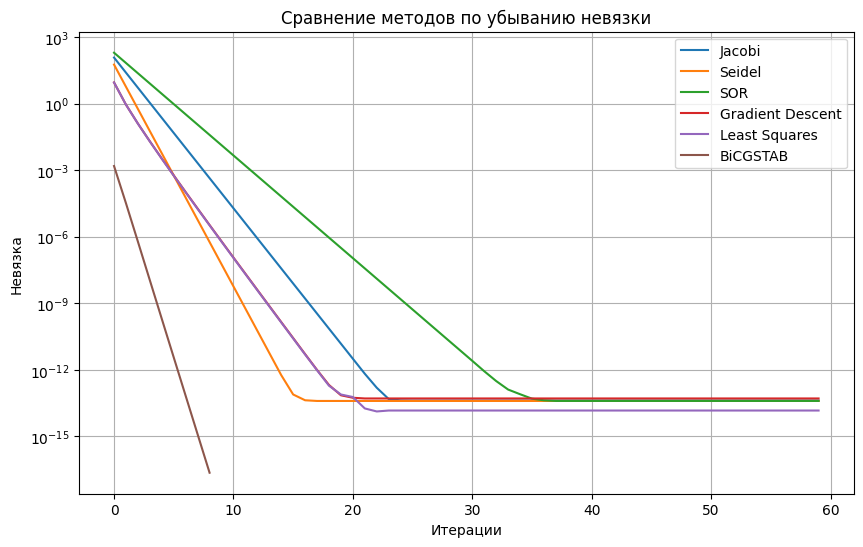

In [108]:
methods = {
    "Jacobi": jacobi,
    "Seidel": seidel,
    "SOR": sor,
    "Gradient Descent": gradient_descent,
    "Least Squares": least_squares,
    "BiCGSTAB": bicgstab
}

plt.figure(figsize=(10, 6))

for method_name, method in methods.items():
    _, residuals = method(A, f)
    plt.plot(residuals, label=method_name)

plt.yscale("log")
plt.xlabel("Итерации")
plt.ylabel("Невязка")
plt.title("Сравнение методов по убыванию невязки")
plt.legend()
plt.grid(True)
plt.show()